## Natural Language Processing
### Movie Review Sentiment Analysis
### Data Source: https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only/overview


In [1]:
# import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk import pos_tag
from nltk.tokenize import TreebankWordTokenizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 13
treebank = TreebankWordTokenizer()
%matplotlib inline

Let us begin by exploring the data files.

In [2]:
# load all files
train_set = pd.read_csv("train.tsv", sep='\t')
test_set = pd.read_csv("test.tsv", sep='\t')

In [3]:
# explore training set
train_set.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
# since PhraseId is unique, let us make it the index of our dataframe
train_set.set_index('PhraseId', inplace=True)
train_set.head()

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,A series of escapades demonstrating the adage ...,1
2,1,A series of escapades demonstrating the adage ...,2
3,1,A series,2
4,1,A,2
5,1,series,2


In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156060 entries, 1 to 156060
Data columns (total 3 columns):
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
# check if there are any duplicate entries that might compicate model building
df = train_set.drop_duplicates(subset = ['Phrase'], keep='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156060 entries, 1 to 156060
Data columns (total 3 columns):
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


There are 156060 non-null observations and 4 features in the training set.

In [7]:
# check number of unique labels
train_set['Sentiment'] = pd.Categorical(train_set['Sentiment'], ordered=True)
train_set['Sentiment'].dtype

CategoricalDtype(categories=[0, 1, 2, 3, 4], ordered=True)

The target 'Sentiment' has 5 unique labels [0, 1, 2, 3, 4] corresponding to the sentiments ['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive'] respectively.

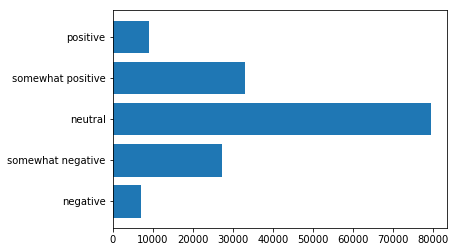

In [8]:
# most frequent sentiments in the training set
train_set['Sentiment'].value_counts().sort_index().plot(kind='barh', width=0.8)
plt.yticks([0,1,2,3,4], ['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive'])
plt.show()

In [9]:
print("Total number of sentences:", train_set.groupby('SentenceId').sum().shape[0])
print("Average number of phrases per sentence:", int(train_set.groupby('SentenceId').count().mean()[0]))

Total number of sentences: 8529
Average number of phrases per sentence: 18


Let us now look at the wordclouds for each of the five sentiments.

In [38]:
# join all reviews of the same sentiment
# extract adjectives and adjective-noun pairs using Regexpparser
pattern = 'Chunk : {<JJ>+<NN>?}'
cp = nltk.RegexpParser(pattern)
review = []
for i in range(5):
#     text = " ".join(list(train_set.loc[train_set['Sentiment']==i,'Phrase']))
    tags = pos_tag(treebank.tokenize(" ".join(list(train_set.loc[train_set['Sentiment']==i,'Phrase']))))
    cs = cp.parse(tags)
    adjectives = []
    for subtree in cs.subtrees(filter=lambda t:t.label()=='Chunk'):
        sub = []
        for i,j in subtree:
            # remove redundant words like 'film' and 'movie'
            if i not in ['movie', 'film']:
                sub.append(i)
            adj = " ".join(sub)
        if adj not in adjectives:
            adjectives.append(adj)
    review.append(", ".join(adjectives))

# list of wordcloud titles
labels = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']

In [39]:
def wordcloud_display(i):
    """
    takes the sentiment value and plots a wordcloud for its contents
    """
    wordcloud = WordCloud(width=600, height=400, prefer_horizontal=0.9, background_color='white', stopwords=STOPWORDS).generate(review[i])
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(labels[i]+' Sentiments\n', fontsize=15)
    plt.show()

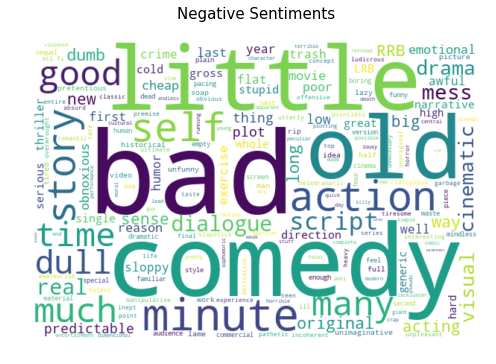

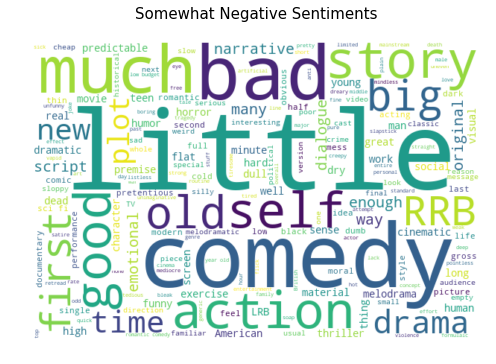

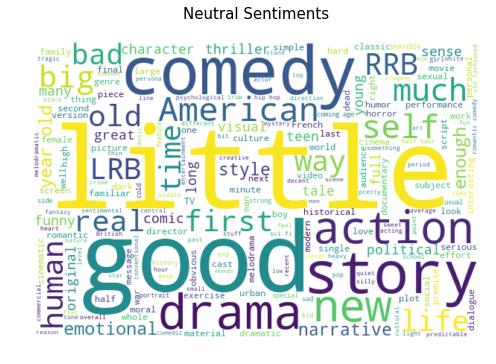

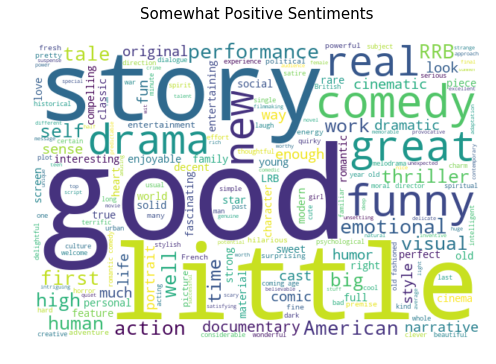

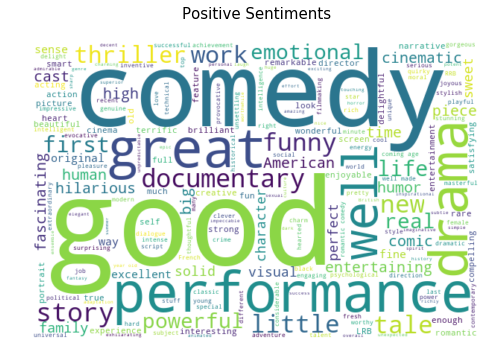

In [40]:
for i in range(5):
    wordcloud_display(i)

These wordclouds tell us a great deal about the adjectives used to describe each type of sentiment.

In [13]:
# explore test set
test_set.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [14]:
# make PhraseId the index for consistency
test_set.set_index('PhraseId', inplace=True)
test_set.head()

,SentenceId,Phrase
PhraseId,,
156061,8545,An intermittently pleasing but mostly routine ...
156062,8545,An intermittently pleasing but mostly routine ...
156063,8545,An
156064,8545,intermittently pleasing but mostly routine effort
156065,8545,intermittently pleasing but mostly routine


In [15]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66292 entries, 156061 to 222352
Data columns (total 2 columns):
SentenceId    66292 non-null int64
Phrase        66292 non-null object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


The test set has 66292 non-null entries and 3 features. 

Let the final output contain the unique Phrase id and Sentiment label.

In [17]:
train_set.groupby('SentenceId').sum().info()
# there are total 8529 sentences

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8529 entries, 1 to 8544
Data columns (total 1 columns):
Phrase    8529 non-null object
dtypes: object(1)
memory usage: 133.3+ KB


### Let us model a NaiveBayes Classifier for our sentiment analysis problem. Since we are dealing with text data, they first need to be converted to numeric types. We would combine the train and test sets along axis=0 and transform them into a Tf-Idf matrix.

In [18]:
# concat the train and test set where the first 156060 rows belong to train set and the next 66292 belong to original
# test set
intermediate = pd.concat([train_set['Phrase'], test_set['Phrase']])

In [19]:
transformer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
X = transformer.fit_transform(intermediate)
print("Some feature names: \n", transformer.get_feature_names()[0:10])
print("\nSome transformed tf-idf values: \n", X[0:5].toarray())

Some feature names: 
 ['00', '000', '000 leagues', '000 times', '007', '007 clone', '007 fly', '10', '10 000', '10 15']

Some transformed tf-idf values: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


These feature names suggest that there are unnecessary numbers in the text data and need to be removed.

In [20]:
intermediate = intermediate.apply(lambda sentence: "".join(char for char in sentence if not char.isdigit()))
intermediate.head(10)
print("Index of intermediate dataframe: \n", intermediate.index)
print("Shape of dataframe: ", intermediate.shape)

Index of intermediate dataframe: 
 Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            222343, 222344, 222345, 222346, 222347, 222348, 222349, 222350,
            222351, 222352],
           dtype='int64', name='PhraseId', length=222352)
Shape of dataframe:  (222352,)


In [21]:
X = transformer.fit_transform(intermediate)
print("Some feature names:\n", transformer.get_feature_names()[0:10])
print("\nSome transformed tf-idf values:\n", X[0:5].toarray())

Some feature names:
 ['aaa', 'aaa action', 'aaliyah', 'aaliyah gets', 'aaliyah rarely', 'aaliyah starring', 'aan', 'aan opportunity', 'abagnale', 'abagnale antics']

Some transformed tf-idf values:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


These feature names look much better than the previous numbers. Now, let's split this into original training and test sets.

In [22]:
# Original train data
X_train = X[:156060]
y_train = train_set.loc[:,'Sentiment']
X_train.shape

(156060, 98288)

In [23]:
# Original test data
X_test = X[156060:]
X_test.shape

(66292, 98288)

We will first build our model using the whole training set and dividing it into train and cross validation set.

In [24]:
xtrain, xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

In [25]:
# call the model and fit data
nb = MultinomialNB()
nb.fit(xtrain, ytrain)
print("Some predictions: ")
nb.predict(xtrain[0:6])

Some predictions: 


array([2, 1, 1, 2, 2, 2], dtype=int64)

In [26]:
print("Training Accuracy: ", nb.score(xtrain, ytrain))
print("Test Accuracy: ", nb.score(xtest, ytest))

Training Accuracy:  0.6765026271946687
Test Accuracy:  0.6039664231705755


As the training and test accuracy isn't very high, we will now use the entire training set to train our DecisionTreeClassifier and make predictions for the test set.

In [27]:
model = MultinomialNB()

In [28]:
model.fit(X_train, y_train)
print("Training Accuracy of the final model: ", model.score(X_train, y_train))

Training Accuracy of the final model:  0.6825323593489684


In [30]:
# final predictions
predictions = pd.DataFrame()
predictions['PhraseId'] = test_set.index
predictions['Sentiment'] = model.predict(X_test)
# display head of the final dataframe 
predictions.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3
